In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import copy
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data.sampler import SubsetRandomSampler

%matplotlib inline

## Construct Network

In [2]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4*4*50, 500)
        self.fc2 = nn.Linear(500, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*50)  # reshape the matrix
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [3]:
class DNN(nn.Module):
    def __init__(self):
        super(DNN, self).__init__()
        self.fc1 = nn.Linear(28*28, 500)
        self.fc2 = nn.Linear(500, 10)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [4]:
class LSTM(nn.Module):
    def __init__(self):
        super(LSTM, self).__init__()
        self.rnn = nn.LSTM(
            input_size=28,
            hidden_size=64,
            num_layers=1,
            batch_first=True,
            bidirectional=True
        )
        self.fc1 = nn.Linear(128, 10)

    def forward(self, x):
        # x_in shape (batch, seq_len, input_size)
        # x_out shape (batch, seq_len, num_directions * hidden_size)
        # h_n shape (n_layers, batch, hidden_size)
        # h_c shape (n_layers, batch, hidden_size)
        x, (h_n, h_c) = self.rnn(x, None)   # hidden nodes are all initialized with 0

        x = self.fc1(x[:, -1, :])
        return F.log_softmax(x, dim=1)

## Define training and testing process

In [5]:
def train(model, device, train_loader, optimizer, epoch, log_interval, model_str="CNN", verbal=False):
    L = list()  # store the losses in a list
    A = list()  # store the accuracies in a list
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        if model_str == "DNN":
            data = data.view(-1, 28*28)
        elif model_str == "LSTM":
            data = data.view(-1, 28, 28)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            accuracy = pred.eq(target.view_as(pred)).sum().item() / len(data)
            if verbal:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\tAccuracy: {:.2f}%'.format(
                    epoch, batch_idx * len(data), len(train_loader.dataset),
                    100. * batch_idx / len(train_loader), loss.item(), accuracy*100))
            L.append(loss.item())
            A.append(accuracy)
    return [L, A]

In [38]:
def test(model, device, test_loader, model_str="CNN", verbal=False):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            if model_str == "DNN":
                data = data.view(-1, 28*28)
            elif model_str == "LSTM":
                data = data.view(-1, 28, 28)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= (len(test_loader)*test_loader.batch_size)
    accuracy = correct / (len(test_loader)*test_loader.batch_size)
    if verbal:
        print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
            test_loss, correct, len(test_loader.dataset),
            100. * correct / len(test_loader.dataset)))
    return [test_loss, accuracy]

## Format results

In [7]:
def format_result(results):
    vis_dict = {}
    for k in list(results.keys()):
        ls_train = list()
        for i in range(len(results[k])):
            ls_train[len(ls_train):len(ls_train)] = results[k][i][0]

        ls_test = list()
        ls_test_idx = list()
        ls_test.append(lt_ini)
        ls_test_idx.append(0)
        for i in range(len(results[k])):
            ls_test.append(results[k][i][2])
            ls_test_idx.append((i+1)*len(results[k][i][0])-1)

        acc_train = list()
        for i in range(len(results[k])):
            acc_train[len(acc_train):len(acc_train)] = results[k][i][1]
        len(ls_train)

        acc_test = list()
        acc_test_idx = list()
        acc_test.append(acc_ini)
        acc_test_idx.append(0)
        for i in range(len(results[k])):
            acc_test.append(results[k][i][3])
            acc_test_idx.append((i+1)*len(results[k][i][0])-1)

        vis_dict[k] = {"ls_train": copy.deepcopy(ls_train), "ls_test": copy.deepcopy(ls_test),
                       "ls_test_idx": copy.deepcopy(ls_test_idx), "acc_train": copy.deepcopy(acc_train),
                       "acc_test": copy.deepcopy(acc_test), "acc_test_idx": copy.deepcopy(acc_test_idx)}
    return vis_dict

## Plots

In [8]:
def plot_result(vis_dict,target_name):
    target = {}
    if target_name=="loss":
        target[0] = "ls_train"
        target[1] = "ls_test"
        target[2] = "ls_test_idx"
    elif target_name=="accuracy":
        target[0] = "acc_train"
        target[1] = "acc_test"
        target[2] = "acc_test_idx"
    
    plt.figure(figsize=[16,8])
    plt.grid(b=True)
    for k in list(vis_dict.keys()):
        plt.plot(vis_dict[k][target[0]],label=str(k)+"_train")
        # Uncomment below to draw validationi (test) results.
        plt.plot(vis_dict[k][target[2]], vis_dict[k][target[1]],label=str(k)+"_test")
        #plt.plot(vis_dict[k][target[2]], vis_dict[k][target[1]], 'r.',label=str(k)+"_test")

    plt.title(target_name)
    plt.legend()
    plt.show()

## Load Dataset

In [73]:
# !! parameters !!
no_cuda = False
seed = 1
batch_size = 64
test_batch_size = 1000

torch.manual_seed(seed)
use_cuda = not no_cuda and torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

# load dataset
kwargs = {'num_workers': 8, 'pin_memory': True} if use_cuda else {}
transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_set = datasets.MNIST('../data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, **kwargs)
test_set = datasets.MNIST('../data', train=False, transform=transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=test_batch_size, shuffle=True, **kwargs)

## Go through Training and Testing Procedure (Test Optimizers)

In [78]:
# !! parameters !!
epochs = 2
log_interval = 10
save_model = False

# !! NOTE: To select model, just change "model_name" !!
model_name = "CNN"

models = {"DNN": DNN().to(device),
          "CNN": CNN().to(device),
          "LSTM": LSTM().to(device)}

model = models[model_name]

state_dict = copy.deepcopy(model.state_dict())

# !! NOTE: Change this to add, delete or change parameters of optimizers. !!
opts = {"SGD": optim.SGD(model.parameters(), lr=0.01),
        "SGDM": optim.SGD(model.parameters(), lr=0.01, momentum=0.9),
        "Adagrad": optim.Adagrad(model.parameters()),
        "RMSprop": optim.RMSprop(model.parameters(), lr=0.001, alpha=0.9),
        "Adadelta": optim.Adadelta(model.parameters()),
        "Adam": optim.Adam(model.parameters(), lr=0.001)}

results = {}

for k in list(opts.keys()):
    
    model.load_state_dict(copy.deepcopy(state_dict))
    optimizer = opts[k]
    # optimizer = optim.SGD(model.parameters())
    # optimizer = optim.Adadelta(model.parameters())

    # train and test; store the results into a list
    lss = []
    lt_ini, acc_ini = test(model, device, test_loader, model_str=model_name)
    for epoch in range(1, epochs + 1):
        [l, acc] = train(model, device, train_loader, optimizer, epoch, log_interval, model_str=model_name)
        [lt, acct] = test(model, device, test_loader, model_str=model_name)
        lss.append([l, acc, lt, acct])
    
    results[k] = copy.deepcopy(lss)

    if (save_model):
        torch.save(model.state_dict(), model_name+"_mnist.pt")

## Format results

In [79]:
vis_dict = format_result(results)

## Plot loss

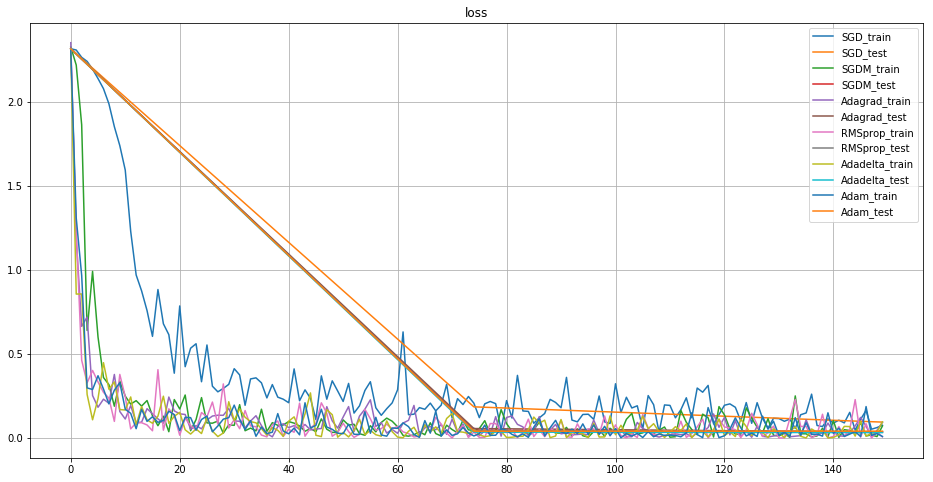

In [80]:
plot_result(vis_dict,"loss")

## Plot accuracy

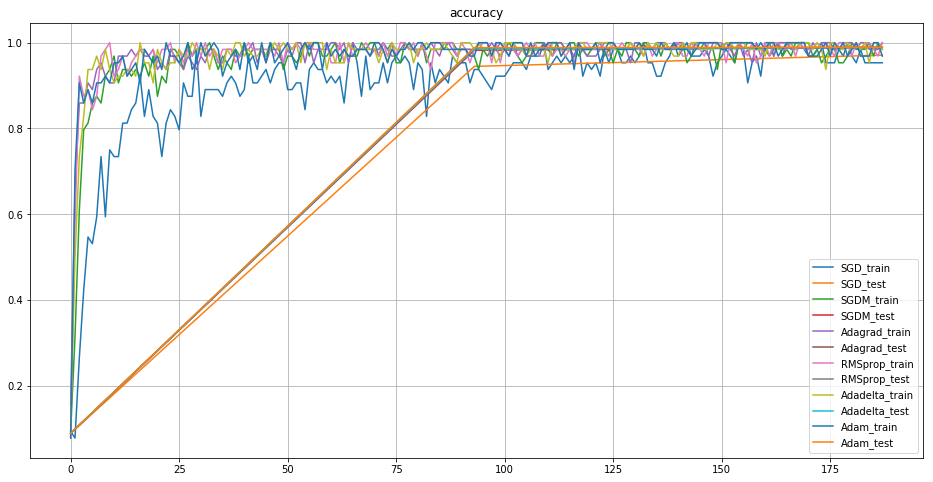

In [100]:
plot_result(vis_dict,"accuracy")

## Test Networks

In [33]:
# !! parameters !!
epochs = 2
log_interval = 10
save_model = False

models = {"DNN": DNN().to(device),
          "CNN": CNN().to(device),
          "LSTM": LSTM().to(device)}

# Testing optimizer
opt = "Adam"

results = {}

for model_name in list(models.keys()):
    model = models[model_name]
    state_dict = copy.deepcopy(model.state_dict())
    model.load_state_dict(copy.deepcopy(state_dict))
    
    ## Set optimizer parameters here
    optimizer = getattr(optim, opt)(model.parameters(), lr=0.001)

    # train and test; store the results into a list
    lss = []
    lt_ini, acc_ini = test(model, device, test_loader, model_str=model_name)
    for epoch in range(1, epochs + 1):
        [l, acc] = train(model, device, train_loader, optimizer, epoch, log_interval, model_str=model_name)
        [lt, acct] = test(model, device, test_loader, model_str=model_name)
        lss.append([l, acc, lt, acct])
    
    results[model_name] = copy.deepcopy(lss)

    if (save_model):
        torch.save(model.state_dict(), model_name+"_mnist.pt")

In [34]:
vis_dict = format_result(results)

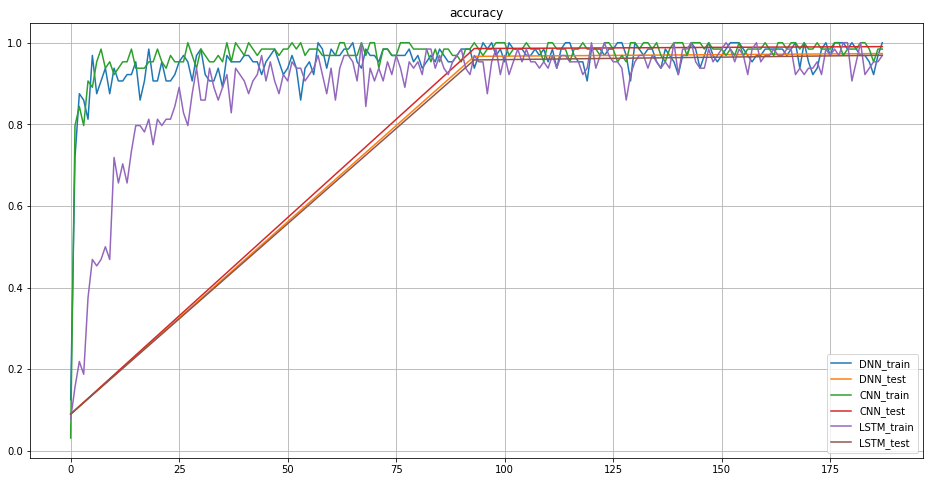

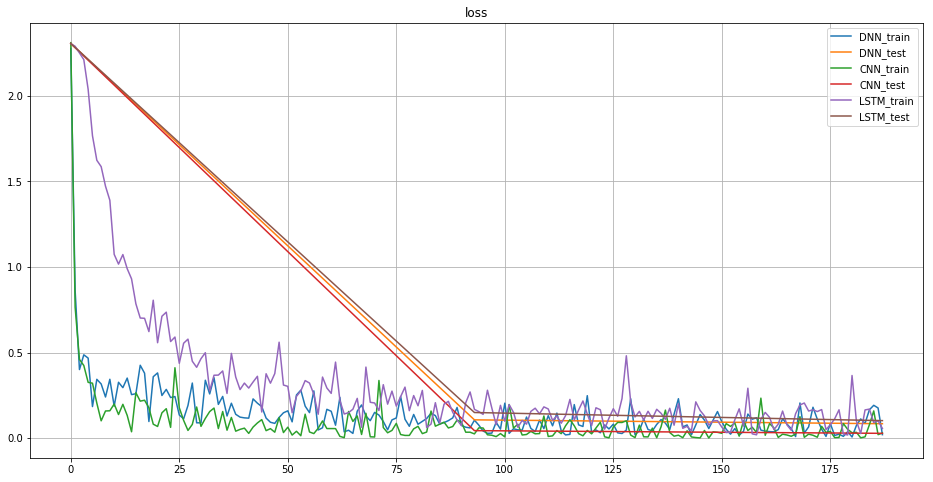

In [65]:
plot_result(vis_dict,"accuracy")
plot_result(vis_dict,"loss")

## Test Parameters of Optimizer (only use testing dataset)

In [94]:
# !! parameters !!
epochs = 2
log_interval = 10
save_model = False

# !! NOTE: To select model, just change "model_name" !!
model_name = "CNN"

models = {"DNN": DNN().to(device),
          "CNN": CNN().to(device),
          "LSTM": LSTM().to(device)}

model = models[model_name]

state_dict = copy.deepcopy(model.state_dict())

# Testing optimizer and parameter
opt = "Adam"                           ## name of optimizer
para = "lr"                            ## name of parameter
prange = np.arange(0.001,0.02,0.005)  ## range of parameter

results = {}

for k in prange:
    model.load_state_dict(copy.deepcopy(state_dict))
    
    ## Set optimizer parameters in kwargs (need to add both testing parameter and fixed parameters)
    kwargs = {para: k}
    optimizer = getattr(optim, opt)(model.parameters(), **kwargs)
    
    # train and test; store the results into a list
    lss = []
    lt_ini, acc_ini = test(model, device, test_loader, model_str=model_name)
    for epoch in range(1, epochs + 1):
        [l, acc] = train(model, device, train_loader, optimizer, epoch, log_interval, model_str=model_name)
        [lt, acct] = test(model, device, test_loader, model_str=model_name)
        lss.append([l, acc, lt, acct])
    
    key = para+"=%.3f" % k
    results[key] = copy.deepcopy(lss)

    if (save_model):
        torch.save(model.state_dict(), model_name+"_mnist.pt")

In [95]:
vis_dict = format_result(results)

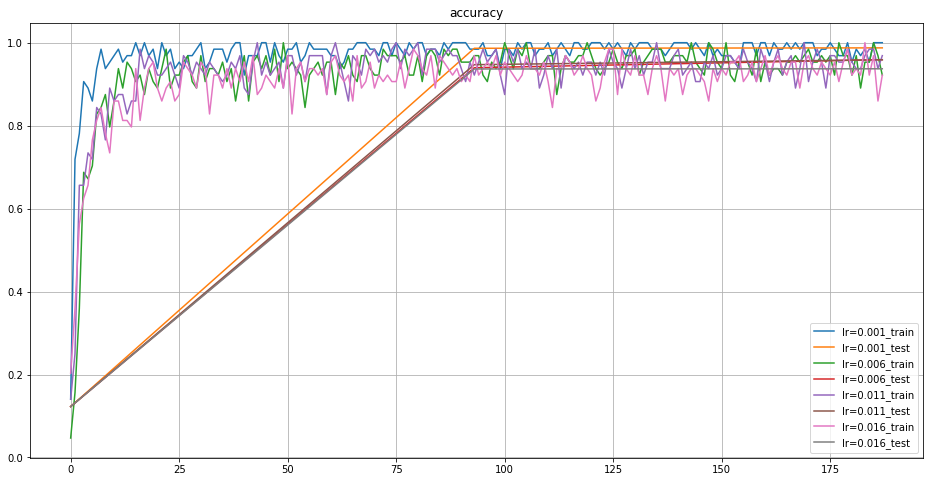

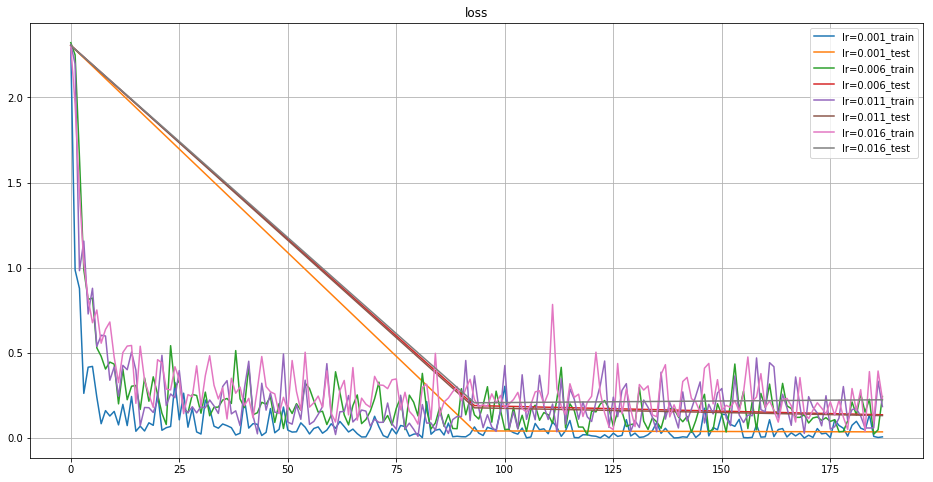

In [96]:
plot_result(vis_dict,"accuracy")
plot_result(vis_dict,"loss")

## Tune Parameters of Optimizer (K-fold cross validation)

In [49]:
def get_indices(n_splits, num_sample):
    fold_sizes = np.ones(n_splits) * int(num_sample/n_splits)
    fold_sizes[0:(num_sample % n_splits)] += 1
    indices = np.arange(num_sample).astype(int)
    current = 0
    for fold_size in fold_sizes:
        start = current
        stop =  current + fold_size
        current = stop
        yield(indices[int(start):int(stop)])

def k_folds(n_splits, num_sample):
    indices = np.arange(num_sample).astype(int)
    idx = 0
    for val_idx in get_indices(n_splits, num_sample):
        train_idx = np.setdiff1d(indices, val_idx)
        idx = idx+1
        yield idx, train_idx, val_idx

In [74]:
# !! parameters !!
batch_size = 64
test_batch_size = 1000
epochs = 2
log_interval = 10
save_model = False

# !! NOTE: To select model, just change "model_name" !!
model_name = "CNN"

models = {"DNN": DNN().to(device),
          "CNN": CNN().to(device),
          "LSTM": LSTM().to(device)}

model = models[model_name]

state_dict = copy.deepcopy(model.state_dict())

# !! NOTE: Change this to add, delete or change parameters of optimizers. !!
opts = {"SGD": optim.SGD(model.parameters(), lr=0.01),
        "SGDM": optim.SGD(model.parameters(), lr=0.01, momentum=0.9),
        "Adagrad": optim.Adagrad(model.parameters()),
        "RMSprop": optim.RMSprop(model.parameters(), lr=0.001, alpha=0.9),
        "Adadelta": optim.Adadelta(model.parameters()),
        "Adam": optim.Adam(model.parameters(), lr=0.001)}
optimizer = opts["SGD"]


results = {}

## K-fold cross validation using trainin set
k_fold = 5
num_train = len(train_set)
for idx, train_idx, valid_idx in k_folds(k_fold,num_train):
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)
    train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, sampler=train_sampler, **kwargs)
    valid_loader = torch.utils.data.DataLoader(train_set, batch_size=test_batch_size, sampler=valid_sampler, **kwargs)    
    model.load_state_dict(copy.deepcopy(state_dict))

    # train and test; store the results into a list
    lss = []
    lt_ini, acc_ini = test(model, device, valid_loader, model_str=model_name)
    for epoch in range(1, epochs + 1):
        [l, acc] = train(model, device, train_loader, optimizer, epoch, log_interval, model_str=model_name)
        [lt, acct] = test(model, device, valid_loader, model_str=model_name)
        lss.append([l, acc, lt, acct])
    
    key = "%dFold" % idx
    results[key] = copy.deepcopy(lss)

    if (save_model):
        torch.save(model.state_dict(), model_name+"_mnist.pt")

In [75]:
vis_dict = format_result(results)

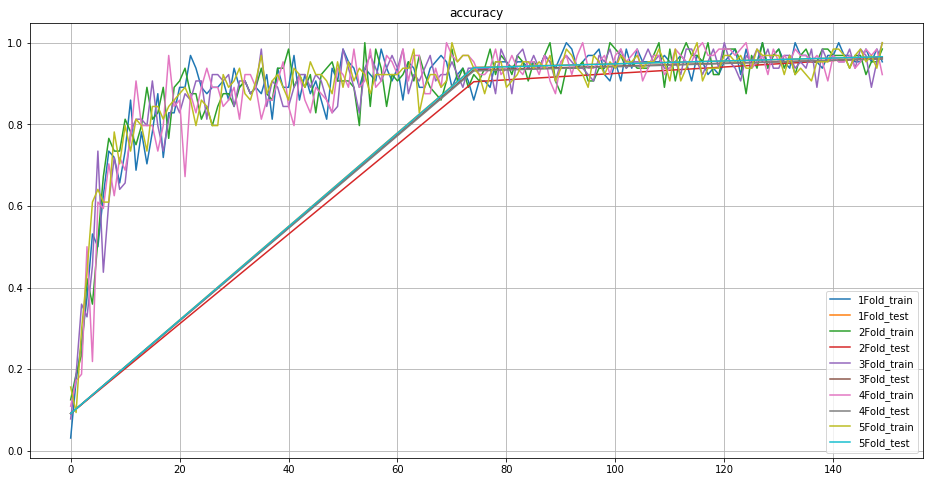

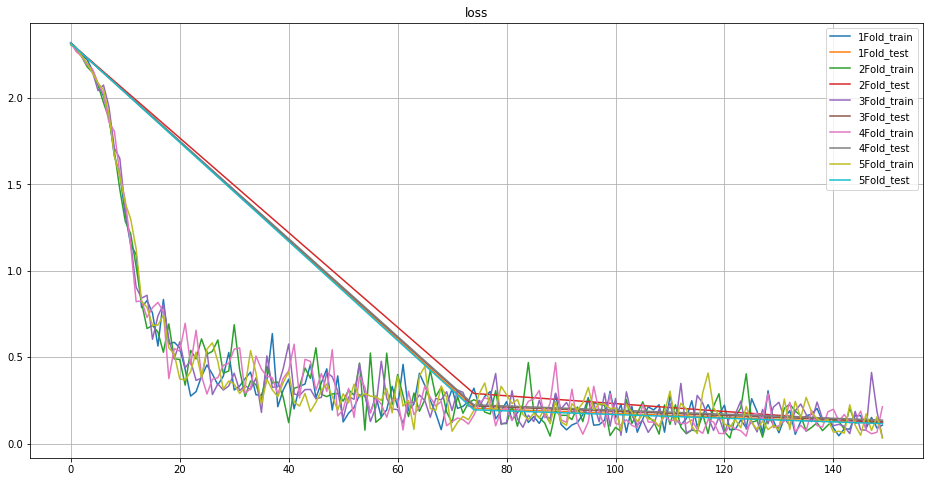

Avg. validation accuracy:  0.96295


In [77]:
plot_result(vis_dict,"accuracy")
plot_result(vis_dict,"loss")

## Average validation accuracy
cross_val_acc = 0
for k in vis_dict.keys():
    cross_val_acc += vis_dict[k]["acc_test"][epoch]
cross_val_acc /= k_fold
print("Avg. validation accuracy: ",cross_val_acc)